In [3]:
!pip install python-dotenv


Defaulting to user installation because normal site-packages is not writeable


In [4]:
import os
from dotenv import load_dotenv

load_dotenv()  # loads variables from .env


True

In [5]:
import pandas as pd
import numpy as np

In [6]:
sessions = pd.read_csv('website_sessions.csv')
orders = pd.read_csv('orders.csv')
pageviews = pd.read_csv('website_pageviews.csv')
order_items = pd.read_csv('order_items.csv')
order_item_refunds = pd.read_csv('order_item_refunds.csv')
products = pd.read_csv('products.csv')


# 1. Data Cleaning
## 1.1 Check structure and datatypes


In [7]:
sessions.info()
orders.info()
pageviews.info()
order_items.info()
order_item_refunds.info()
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472871 entries, 0 to 472870
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   website_session_id  472871 non-null  int64 
 1   created_at          472871 non-null  object
 2   user_id             472871 non-null  int64 
 3   is_repeat_session   472871 non-null  int64 
 4   utm_source          389543 non-null  object
 5   utm_campaign        389543 non-null  object
 6   utm_content         389543 non-null  object
 7   device_type         472871 non-null  object
 8   http_referer        432954 non-null  object
dtypes: int64(3), object(6)
memory usage: 32.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32313 entries, 0 to 32312
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            32313 non-null  int64  
 1   created_at          32313 non-null  obje

we can see that the created_at column is suppose to be in datetime datatype but its in object. So, we have to convert the datatype into date format.
If it is not converted into datetime then monthly trend maynot work and conversion over time will fail.

### 1.1.1 Convert created_at to datetime format


In [8]:
sessions['created_at'] = pd.to_datetime(sessions['created_at'])
orders['created_at'] = pd.to_datetime(orders['created_at'])
pageviews['created_at'] = pd.to_datetime(pageviews['created_at'])
order_items['created_at'] = pd.to_datetime(order_items['created_at'])
order_item_refunds['created_at'] = pd.to_datetime(order_item_refunds['created_at'])


In [9]:
sessions.info()
orders.info()
pageviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472871 entries, 0 to 472870
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   website_session_id  472871 non-null  int64         
 1   created_at          472871 non-null  datetime64[ns]
 2   user_id             472871 non-null  int64         
 3   is_repeat_session   472871 non-null  int64         
 4   utm_source          389543 non-null  object        
 5   utm_campaign        389543 non-null  object        
 6   utm_content         389543 non-null  object        
 7   device_type         472871 non-null  object        
 8   http_referer        432954 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 32.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32313 entries, 0 to 32312
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              ----

In [10]:
# checking min and max time span
print(sessions['created_at'].min(), sessions['created_at'].max())
print(orders['created_at'].min(), orders['created_at'].max())
print(pageviews['created_at'].min(), pageviews['created_at'].max())


2012-03-19 08:04:16 2015-03-19 07:59:08
2012-03-19 10:42:46 2015-03-19 05:38:31
2012-03-19 08:04:16 2015-03-19 07:59:32


We can see that the records are from 2012 april 19 to 2015 april 19. 

## 1.2. Categorical Data Cleaning(UTM and Channels)
Even when there are no nulls, UTM field may have NaN, empty strings or inconsistent values.

In [11]:
# inspect UTM cloumns
sessions[['utm_source', 'utm_campaign', 'utm_content', 'device_type']].head(10)


,utm_source,utm_campaign,utm_content,device_type
0,gsearch,nonbrand,g_ad_1,mobile
1,gsearch,nonbrand,g_ad_1,desktop
2,gsearch,nonbrand,g_ad_1,desktop
3,gsearch,nonbrand,g_ad_1,desktop
4,gsearch,nonbrand,g_ad_1,mobile
5,gsearch,nonbrand,g_ad_1,desktop
6,gsearch,nonbrand,g_ad_1,mobile
7,gsearch,nonbrand,g_ad_1,mobile
8,gsearch,nonbrand,g_ad_1,mobile
9,gsearch,nonbrand,g_ad_1,mobile


In [12]:
sessions['utm_source'].unique()



array(['gsearch', nan, 'bsearch', 'socialbook'], dtype=object)

In [13]:
sessions['utm_campaign'].unique()

array(['nonbrand', nan, 'brand', 'pilot', 'desktop_targeted'],
      dtype=object)

In [14]:
sessions['utm_content'].unique()

array(['g_ad_1', nan, 'g_ad_2', 'b_ad_2', 'b_ad_1', 'social_ad_1',
       'social_ad_2'], dtype=object)

In [15]:
sessions['device_type'].unique()

array(['mobile', 'desktop'], dtype=object)

In [16]:
sessions[['utm_source','utm_campaign','utm_content']].isnull().sum()


utm_source      83328
utm_campaign    83328
utm_content     83328
dtype: int64

In [17]:
sessions['utm_source'] = sessions['utm_source'].fillna('direct')
sessions['utm_campaign'] = sessions['utm_campaign'].fillna('none')
sessions['utm_content'] = sessions['utm_content'].fillna('none')


In [18]:
sessions[['utm_source','utm_campaign','utm_content']].isnull().sum()

utm_source      0
utm_campaign    0
utm_content     0
dtype: int64

In [19]:
# create marketing channel column
def channel_group(row):
    if row['utm_source'] == 'direct' :
        return 'direct'
    elif row ['utm_source'] in ['gsearch', 'bsearch'] :
        return 'paid_search'
    elif row ['utm_source'] == 'socialbook' :
        return 'paid_social'
    else:
        return 'other'

sessions['channel_group'] = sessions.apply(channel_group, axis=1)





#Or 

mapping = {
    'direct': 'direct',
    'gsearch': 'paid_search',
    'bsearch': 'paid_search',
    'socialbook': 'paid_social'
}

sessions['channel_group'] = sessions['utm_source'].map(mapping).fillna('other')

In [20]:
sessions['channel_group'].value_counts()


channel_group
paid_search    378858
direct          83328
paid_social     10685
Name: count, dtype: int64

This result shows how website sessions are distributed across major marketing channels after standardizing UTM data. Paid Search is the dominant channel with 378,858 sessions, indicating that the majority of traffic is driven by search advertising on platforms such as Google and Bing. This suggests a strong reliance on paid search for acquisition, making its performance critical to overall traffic and revenue. Direct traffic accounts for 83,328 sessions, reflecting brand strength and repeat usage through untagged visits such as bookmarks or direct URL access, and typically represents a lower-cost, higher-intent audience. Paid Social contributes 10,685 sessions, making it a smaller but strategically important channel, often associated with awareness or experimental campaigns.

## 1.3 Validate primary keys and table relationships
If IDs are duplicated or relationships are broken, conversion rates, revenue, and funnel metrics will be wrong — even if code runs without errors.

### 1.3.1 Validate Primary keys(uniqueness check)

In [21]:
sessions['website_session_id'].is_unique

True

In [22]:
orders['order_id'].is_unique

True

In [23]:
pageviews['website_pageview_id'].is_unique


True

In [24]:
order_items['order_item_id'].is_unique


True

In [25]:
order_item_refunds['order_item_refund_id'].is_unique


True

### 1.3.2 Validate Table relationships
Confirm tables are link correctly or not.

In [26]:
orders['website_session_id'].isin(sessions['website_session_id']).all()


np.True_

In [27]:
pageviews['website_session_id'].isin(sessions['website_session_id']).all()


np.True_

In [28]:
order_items['order_id'].isin(orders['order_id']).all()


np.True_

In [29]:
order_item_refunds['order_item_id'].isin(order_items['order_item_id']).all()


np.True_

### 1.3.3 Cardinality Check


In [30]:
# how many orders per session?

orders.groupby('website_session_id')['order_id'].count().describe()


count    32313.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: order_id, dtype: float64

In [31]:
# how many pageviews pers sessions?
pageviews.groupby('website_session_id')['website_pageview_id'].count().describe()

count    472871.000000
mean          2.512575
std           1.816384
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           7.000000
Name: website_pageview_id, dtype: float64

Primary keys and table relationships are vailidated to ensure that each dataset had unique identifiers and that foreign keys correctly linked sessions, orders, pageviews, and order items. This step ensures that joins are accurate and that conversion and revenue metrics are not inflated due to duplicated or orphaned records.

# 2. Exploratory Data Analysis (EDA)
In this section, we will understand trend and patterns before drawing conclusions. We will analyze the following:
1. Sessions trend
2. Orders trend
3. Conversion rate trend
4. Channel-level performance

In [32]:
# create time features(monthly)
sessions['month'] = sessions['created_at'].dt.to_period('M')
orders['month'] = orders['created_at'].dt.to_period('M')


## 2.1 Website sessions trend


In [33]:
session_trend = (
    sessions
    .groupby('month')['website_session_id']
    .nunique()
)

session_trend


month
2012-03     1879
2012-04     3734
2012-05     3736
2012-06     3963
2012-07     4249
2012-08     6097
2012-09     6546
2012-10     8183
2012-11    14011
2012-12    10072
2013-01     6401
2013-02     7168
2013-03     6264
2013-04     7971
2013-05     8449
2013-06     8325
2013-07     8903
2013-08     9180
2013-09     9580
2013-10    10773
2013-11    14032
2013-12    15735
2014-01    14825
2014-02    16285
2014-03    15669
2014-04    17353
2014-05    18061
2014-06    17715
2014-07    19038
2014-08    18590
2014-09    19513
2014-10    21526
2014-11    25125
2014-12    29722
2015-01    25337
2015-02    23778
2015-03    15083
Freq: M, Name: website_session_id, dtype: int64

<Axes: title={'center': 'Monthly Website Sessions'}, xlabel='month'>

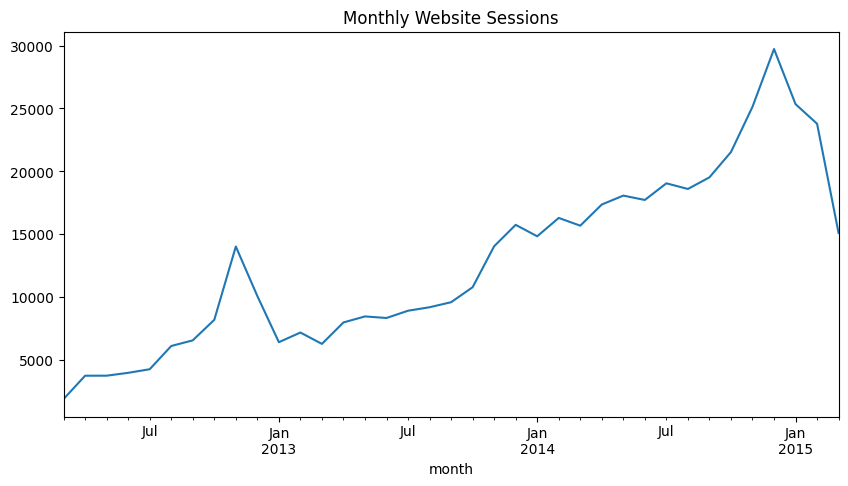

In [34]:
session_trend.plot(
    title = 'Monthly Website Sessions',
    figsize = (10,5)
)

## 2.2 Orders trend

In [35]:
orders_trend = (
    orders
    .groupby('month')['order_id']
    .nunique()
)

orders_trend

month
2012-03      60
2012-04      99
2012-05     108
2012-06     140
2012-07     169
2012-08     228
2012-09     287
2012-10     371
2012-11     618
2012-12     506
2013-01     390
2013-02     498
2013-03     385
2013-04     553
2013-05     571
2013-06     593
2013-07     604
2013-08     608
2013-09     629
2013-10     708
2013-11     861
2013-12    1047
2014-01     982
2014-02    1021
2014-03    1066
2014-04    1241
2014-05    1368
2014-06    1239
2014-07    1286
2014-08    1325
2014-09    1424
2014-10    1609
2014-11    1985
2014-12    2314
2015-01    2098
2015-02    2068
2015-03    1254
Freq: M, Name: order_id, dtype: int64

<Axes: title={'center': 'Monthly orders'}, xlabel='month'>

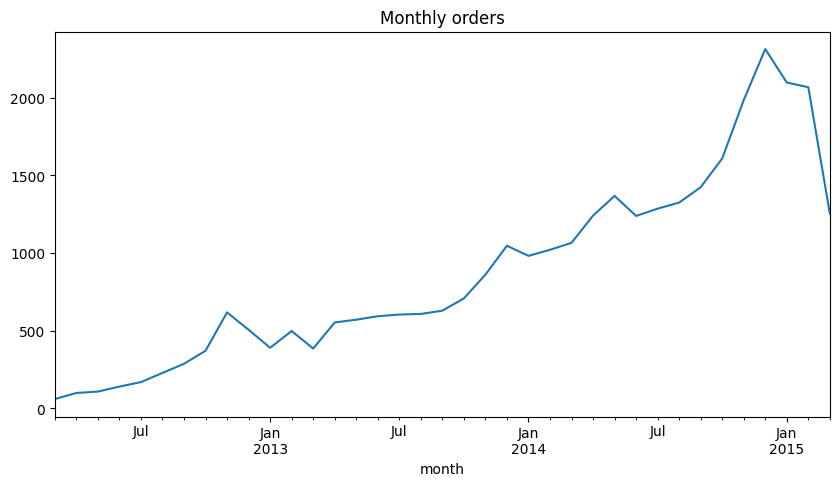

In [36]:
orders_trend.plot(
    title = 'Monthly orders',
    figsize = (10,5)
)
    

## 2.3 Session to order Conversion Rate

In [37]:
#merge session and order(left join)
session_orders = sessions.merge(
    orders[['order_id', 'website_session_id']],
    on = 'website_session_id',
    how = 'left'
)

session_orders.head(5)

,website_session_id,created_at,user_id,is_repeat_session,utm_source,utm_campaign,utm_content,device_type,http_referer,channel_group,month,order_id
0,1,2012-03-19 08:04:16,1,0,gsearch,nonbrand,g_ad_1,mobile,https://www.gsearch.com,paid_search,2012-03,NaN
1,2,2012-03-19 08:16:49,2,0,gsearch,nonbrand,g_ad_1,desktop,https://www.gsearch.com,paid_search,2012-03,NaN
2,3,2012-03-19 08:26:55,3,0,gsearch,nonbrand,g_ad_1,desktop,https://www.gsearch.com,paid_search,2012-03,NaN
3,4,2012-03-19 08:37:33,4,0,gsearch,nonbrand,g_ad_1,desktop,https://www.gsearch.com,paid_search,2012-03,NaN
4,5,2012-03-19 09:00:55,5,0,gsearch,nonbrand,g_ad_1,mobile,https://www.gsearch.com,paid_search,2012-03,NaN


In [38]:
# calculate conversion rate
conversion_monthly = (
    session_orders
    .groupby('month')
    .agg(
        sessions = ('website_session_id', 'nunique'),
        orders = ('order_id', 'nunique')
    )
)

conversion_monthly['conversion_rate'] = (
    conversion_monthly['orders'] / conversion_monthly['sessions']
)

conversion_monthly

,sessions,orders,conversion_rate
month,,,
2012-03,1879,60,0.031932
2012-04,3734,99,0.026513
2012-05,3736,108,0.028908
2012-06,3963,140,0.035327
2012-07,4249,169,0.039774
2012-08,6097,228,0.037395
2012-09,6546,287,0.043844
2012-10,8183,371,0.045338
2012-11,14011,618,0.044108


<Axes: title={'center': 'Monthly Session-to-Order Conversion Rate'}, xlabel='month'>

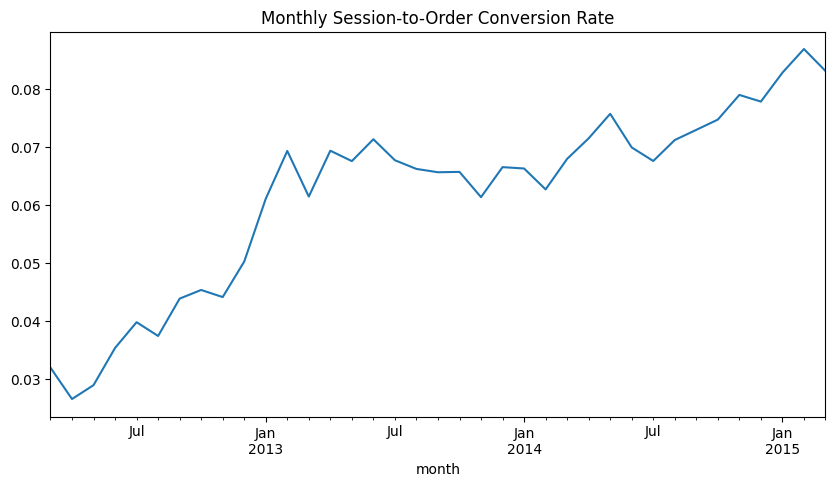

In [39]:
conversion_monthly['conversion_rate'].plot(
    title = 'Monthly Session-to-Order Conversion Rate',
    figsize = (10,5)
)

## 2.4 Channel- level traffic volume

In [40]:
channel_sessions = (
    sessions
    .groupby('channel_group')['website_session_id']
    .nunique()
    .sort_values(ascending=False)
)

channel_sessions

channel_group
paid_search    378858
direct          83328
paid_social     10685
Name: website_session_id, dtype: int64

Website sessions have grown steadily over time, driven by increased marketing activity, with a noticeable spike toward the end of 2014. Orders have followed a similar upward trend, indicating that traffic growth is translating into real sales rather than low-quality visits. Importantly, the session-to-order conversion rate has improved significantly over the same period, rising from roughly 3% to over 7%, which suggests improvements in website performance, traffic quality, or both. Overall, this indicates that business growth is being driven by both higher traffic volume and stronger conversion efficiency.

## 2.5 Channel Level Performance Analysis
Which channel converts best? Which generates the most revenue? Which is most efficient?

## 2.5.1 Sessions, Orders and Conversion Rate by Channel


In [41]:
# merge session and orders
channel_perf = (
    sessions.merge(
        orders[['order_id', 'website_session_id', 'price_usd']],
        on = 'website_session_id',
        how = 'left'
    )
)

In [42]:
# aggregate by channel
channel_summary = (
    channel_perf
    .groupby('channel_group')
    .agg(
        sessions=('website_session_id', 'nunique'),
        orders=('order_id', 'nunique'),
        revenue=('price_usd', 'sum')
    )
)

channel_summary['conversion_rate'] = (
    channel_summary['orders'] / channel_summary['sessions']
)

channel_summary

    

,sessions,orders,revenue,conversion_rate
channel_group,,,,
direct,83328,6118,371433.03,0.073421
paid_search,378858,25852,1544817.39,0.068237
paid_social,10685,343,22259.33,0.032101


In [43]:
# Revenue per session
channel_summary['revenue_per_session'] = (
    channel_summary['revenue'] / channel_summary['sessions']
)

channel_summary


,sessions,orders,revenue,conversion_rate,revenue_per_session
channel_group,,,,,
direct,83328,6118,371433.03,0.073421,4.457482
paid_search,378858,25852,1544817.39,0.068237,4.077563
paid_social,10685,343,22259.33,0.032101,2.083232


Paid search is the main driver of traffic and revenue, making it the company’s primary growth channel, while direct traffic is the most efficient, showing the highest conversion rate and revenue per session due to strong brand-driven demand. Paid social contributes relatively little traffic and revenue and has the lowest efficiency, indicating a need for optimization or reduced investment.

In [44]:
pip install psycopg2-binary sqlalchemy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [45]:
sessions_sql = sessions.drop(columns=['month'], errors='ignore')
orders_sql = orders.drop(columns=['month'], errors='ignore')


In [46]:
from sqlalchemy import create_engine

# Step 1: Database connection details
username = os.getenv("PG_USER")
password = os.getenv("PG_PASSWORD")
host = os.getenv("PG_HOST")
port = os.getenv("PG_PORT")
database = os.getenv("PG_DATABASE")

# Create PostgreSQL engine
engine = create_engine(
    f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}"
)

# Step 2: Load DataFrame into PostgreSQL
tables = {
    "website_sessions": sessions_sql,
    "website_pageviews": pageviews,
    "orders": orders_sql,
    "order_items": order_items,
    "order_item_refunds": order_item_refunds,
    "products": products
}

for table_name, df in tables.items():
    df.to_sql(
        table_name,
        engine,
        if_exists="replace",
        index=False
    )
    
    print(f"Loaded table: {table_name}")




Loaded table: website_sessions
Loaded table: website_pageviews
Loaded table: orders
Loaded table: order_items
Loaded table: order_item_refunds
Loaded table: products
